<a href="https://colab.research.google.com/github/drewwint/PCSM/blob/main/real_sst_data_n-latent-states_verify_subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from IPython.utils.io import capture_output

if 'google.colab' in sys.modules:

    with capture_output() as captured:
      ! pip install watermark hmmlearn nilearn
      # ! pip install --upgrade nilearn

import nilearn
import nilearn.datasets
import nilearn.plotting
import nilearn.image
import nilearn.glm.first_level
from nilearn.glm.first_level import first_level_from_bids
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import watermark
import hmmlearn
from hmmlearn import hmm
import scipy
from scipy.stats import norm, binom, gamma, multivariate_normal
import nibabel as nib
import math
from scipy.stats import gamma
from nilearn.maskers import NiftiLabelsMasker


## Getting Real Data and Cleaning

### Getting SST Data from OpenNeuro

Selecting participants from the ds00030 dataset on openneuro with SST task data.
- We do few participants as a use case but also google collab only has so many resources and doing more a few participants crashes the platform (unless I want to subscribe)

We import get urls filter potential participants and then get the one participant data

In [2]:
from nilearn.datasets import (
    fetch_ds000030_urls,
    fetch_openneuro_dataset,
    select_from_index,
)

_, urls = fetch_ds000030_urls()

exclusion_patterns = [
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-rest*",
    "*task-scap*",
    "*task-task*",
]


urls = select_from_index(
    urls,
    exclusion_filters=exclusion_patterns,
    n_subjects=3
)

data_dir, _ = fetch_openneuro_dataset(urls=urls)




[fetch_ds000030_urls] Added README.md to /root/nilearn_data

[fetch_ds000030_urls] Dataset created in /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed

[fetch_ds000030_urls] Downloading data from https://osf.io/86xj7/download ...

[fetch_ds000030_urls]  ...done. (3 seconds, 0 min)

[fetch_openneuro_dataset] Dataset found in /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/README ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/dataset_description.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/index.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159.html ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_dtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_inflated.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_inflated.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_midthickness.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_midthickness.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_pial.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_pial.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_smoothwm.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_smoothwm.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/anat/sub-10
159_T1w_space-MNI152NLin2009cAsym_warp.h5 ...

[fetch_openneuro_dataset] Downloaded 64331776 of 102374780 bytes (62.8%%,    0.6s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10
159_task-stopsignal_bold_confounds.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10
159_task-stopsignal_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10
159_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset] Downloaded 67051520 of 120927302 bytes (55.4%%,    0.8s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171.html ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_dtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_inflated.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_inflated.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_midthickness.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_midthickness.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_pial.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_pial.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_smoothwm.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_smoothwm.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/anat/sub-10
171_T1w_space-MNI152NLin2009cAsym_warp.h5 ...

[fetch_openneuro_dataset] Downloaded 68468736 of 102374780 bytes (66.9%%,    0.5s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-bht_bold_confounds.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-bht_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-bht_bold_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-stopsignal_bold_confounds.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-stopsignal_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10
171_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset] Downloaded 73613312 of 119658723 bytes (61.5%%,    0.6s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189.html ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_dtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_inflated.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_inflated.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_midthickness.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_midthickness.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_pial.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_pial.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_smoothwm.L.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_smoothwm.R.surf.gii ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/anat/sub-10
189_T1w_space-MNI152NLin2009cAsym_warp.h5 ...

[fetch_openneuro_dataset] Downloaded 57081856 of 102374780 bytes (55.8%%,    0.8s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/func/sub-10
189_task-stopsignal_bold_confounds.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/func/sub-10
189_task-stopsignal_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/func/sub-10
189_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz ...

[fetch_openneuro_dataset] Downloaded 55959552 of 117832957 bytes (47.5%%,    1.1s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.file
s/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/.ramp
.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/absbr
ainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/custo
m_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/desig
n_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/examp
le_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/filte
red_func_data.nii.gz ...

[fetch_openneuro_dataset] Downloaded 37027840 of 55009731 bytes (67.3%%,    0.5s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat0_init.e60127 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat0_init.o60127 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat2_pre.e60564 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat2_pre.o60564 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat3_film.e61431 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat3_film.o61431 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat4_post.e120148 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat4_post.o120148 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat5_stop.e134343 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat5_stop.o134343 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/logs/
feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/mask.
nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/mean_
func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/repor
t_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/bart.feat/stats
/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat0_init.e3328 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat0_init.o3328 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat2_pre.e4486 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat2_pre.o4486 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat3_film.e8788 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat3_film.o8788 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat4_post.e22680 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat4_post.o22680 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat5_stop.e58254 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat5_stop.o58254 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev20.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev21.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev22.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev23.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev24.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev25.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev26.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat0_init.e182384 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat0_init.o182384 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat2_pre.e183363 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat2_pre.o183363 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat3_film.e183962 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat3_film.o183962 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat4_post.e194150 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat4_post.o194150 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat5_stop.e52571 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat5_stop.o52571 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/taskswitch.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.file
s/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/.ramp
.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/absbr
ainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/custo
m_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/desig
n_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/examp
le_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/filte
red_func_data.nii.gz ...

[fetch_openneuro_dataset] Downloaded 53223424 of 53563006 bytes (99.4%%,    0.0s remaining)

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat0_init.e78556 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat0_init.o78556 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat2_pre.e81013 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat2_pre.o81013 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat3_film.e87624 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat3_film.o87624 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat4_post.e98364 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat4_post.o98364 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat5_stop.e126527 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat5_stop.o126527 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/logs/
feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/mask.
nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/mean_
func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/repor
t_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/res4d.nii.gz ...

[fetch_openneuro_dataset] Downloaded 53420032 of 57723221 bytes (92.5%%,    0.1s remaining)

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/bart.feat/stats
/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat0_init.e108303 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat0_init.o108303 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat2_pre.e108630 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat2_pre.o108630 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat3_film.e108856 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat3_film.o108856 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat4_post.e114931 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat4_post.o114931 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat5_stop.e122061 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat5_stop.o122061 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/stopsignal.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev20.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev21.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev22.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev23.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev24.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev25.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev26.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat0_init.e156489 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat0_init.o156489 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat2_pre.e156670 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat2_pre.o156670 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat3_film.e157976 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat3_film.o157976 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat4_post.e188990 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat4_post.o188990 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat5_stop.e99263 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat5_stop.o99263 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10171/taskswitch.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.file
s/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/.ramp
.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/absbr
ainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/custo
m_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/desig
n_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/examp
le_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/filte
red_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat0_init.e69264 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat0_init.o69264 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat2_pre.e69919 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat2_pre.o69919 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat3_film.e73709 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat3_film.o73709 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat4_post.e89262 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat4_post.o89262 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat5_stop.e112528 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat5_stop.o112528 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/logs/
feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/mask.
nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/mean_
func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/repor
t_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/res4d.nii.gz ...

[fetch_openneuro_dataset] Downloaded 42917888 of 59484091 bytes (72.2%%,    0.4s remaining)

[fetch_openneuro_dataset]  ...done. (2 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/bart.feat/stats
/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.file
s/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/.ramp
.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/absbr
ainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev20.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev21.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev22.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev23.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev24.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev25.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev26.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev27.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev28.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev29.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev30.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev31.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev32.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev33.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev34.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev35.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/custo
m_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.ppm ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/desig
n_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/examp
le_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/filte
red_func_data.nii.gz ...

[fetch_openneuro_dataset] Downloaded 58212352 of 61232182 bytes (95.1%%,    0.1s remaining)

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat0_init.e85933 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat0_init.o85933 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat2_pre.e87505 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat2_pre.o87505 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat3_film.e92674 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat3_film.o92674 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat4_post.e177918 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat4_post.o177918 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat5_stop.e27823 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat5_stop.o27823 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/logs/
feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/mask.
nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/mean_
func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/repor
t_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe49.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe50.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe51.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe52.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe53.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe54.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe55.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe56.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe57.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe58.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe59.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe60.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/res4d.nii.gz ...

[fetch_openneuro_dataset] Downloaded 65396736 of 65875426 bytes (99.3%%,    0.0s remaining)

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/scap.feat/stats
/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat0_init.e59026 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat0_init.o59026 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat2_pre.e60122 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat2_pre.o60122 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat3_film.e68451 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat3_film.o68451 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat4_post.e115676 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat4_post.o115676 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat5_stop.e139086 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat5_stop.o139086 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/stopsignal.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/fsl.css ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/3.1r.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/3.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/flirt-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-bg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-logo-big.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-logo.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-logo.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-logo.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fsl-macos-snapshot.tiff ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fslstart.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fslstart.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/fugue-bg.jpg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/tick.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.files/images/vert2.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/.ramp.gif ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/absbrainthresh.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev1.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev10.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev11.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev12.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev13.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev14.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev15.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev16.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev17.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev18.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev19.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev2.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev20.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev21.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev22.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev23.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev24.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev25.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev26.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev3.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev4.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev5.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev6.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev7.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev8.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/custom_timing_files/ev9.txt ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.con ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.frf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.fsf ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.mat ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.min ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.ppm ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design.trg ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design_cov.png ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/design_cov.ppm ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/example_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/filtered_func_data.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat0 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat0_init.e148653 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat0_init.o148653 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat1 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat1a_init ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat2_pre ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat2_pre.e149843 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat2_pre.o149843 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat3_film.e153597 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat3_film.o153597 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat3_stats ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat4_post ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat4_post.e21806 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat4_post.o21806 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat5_stop.e74848 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat5_stop.o74848 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/logs/feat9 ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/mask.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/mean_func.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report_log.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report_poststats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report_prestats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report_reg.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/report_stats.html ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/cope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/dof ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/logfile ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/pe9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/res4d.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/sigmasquareds.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/smoothness ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/threshac1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/tstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/varcope9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat1.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat10.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat11.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat12.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat13.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat14.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat15.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat16.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat17.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat18.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat19.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat2.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat20.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat21.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat22.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat23.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat24.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat25.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat26.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat27.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat28.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat29.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat3.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat30.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat31.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat32.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat33.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat34.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat35.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat36.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat37.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat38.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat39.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat4.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat40.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat41.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat42.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat43.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat44.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat45.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat46.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat47.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat48.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat5.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat6.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat7.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat8.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10189/taskswitch.feat
/stats/zstat9.nii.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/participants.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/anat/sub-10159_T1w.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/anat/sub-10159_T1w.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_b
old.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_b
old.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_e
vents.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/anat/sub-10171_T1w.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/anat/sub-10171_T1w.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-bht_bold.jso
n ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-bht_bold.nii
.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-bht_events.t
sv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-bht_physio.j
son ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-bht_physio.t
sv.gz ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-stopsignal_b
old.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-stopsignal_b
old.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-stopsignal_e
vents.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/anat/sub-10189_T1w.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/anat/sub-10189_T1w.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/func/sub-10189_task-stopsignal_b
old.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/func/sub-10189_task-stopsignal_b
old.nii.gz ...

[fetch_openneuro_dataset]  ...done. (1 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/func/sub-10189_task-stopsignal_e
vents.tsv ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/task-bht_bold.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/task-pamenc_bold.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/task-pamret_bold.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

[fetch_openneuro_dataset] Downloading data from 
https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/task-stopsignal_bold.json ...

[fetch_openneuro_dataset]  ...done. (0 seconds, 0 min)

In [3]:


task_label = "stopsignal"
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep"
(
    models,
    models_run_imgs,
    models_events,
    models_confounds,
) = first_level_from_bids(
    data_dir,
    task_label,
    space_label,
    smoothing_fwhm=5.0,
    derivatives_folder=derivatives_folder,
    n_jobs=2,
    verbose=1,
)

/tmp/ipython-input-124387773.py:9: UserWarning: 
No bold.json found in BIDS folder in:
 /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep.
  ) = first_level_from_bids(
/tmp/ipython-input-124387773.py:9: UserWarning: 'slice_time_ref' not provided and cannot be inferred from metadata.
It will be assumed that the slice timing reference is 0.0 percent of the repetition time.
If it is not the case it will need to be set manually in the generated list of models.
  ) = first_level_from_bids(


[first_level_from_bids] 
Found the following 1 preprocessed BOLD files
- for subject 10159
- for filter: [('task', 'stopsignal'), ('space', 'MNI152NLin2009cAsym')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsig
nal_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

[first_level_from_bids] 
Found the following 1 events files
- for subject 10159
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_events.tsv

[first_level_from_bids] 
Found the following 1 confounds files
- for subject 10159
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsig
nal_desc-confounds_regressors.tsv

[first_level_from_bids] 
Found the following 1 preprocessed BOLD files
- for subject 10171
- for filter: [('task', 'stopsignal'), ('space', 'MNI152NLin2009cAsym')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10171_task-stopsig
nal_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

[first_level_from_bids] 
Found the following 1 events files
- for subject 10171
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/sub-10171/func/sub-10171_task-stopsignal_events.tsv

[first_level_from_bids] 
Found the following 1 confounds files
- for subject 10171
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10171/func/sub-10171_task-stopsig
nal_desc-confounds_regressors.tsv

[first_level_from_bids] 
Found the following 1 preprocessed BOLD files
- for subject 10189
- for filter: [('task', 'stopsignal'), ('space', 'MNI152NLin2009cAsym')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/func/sub-10189_task-stopsig
nal_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

[first_level_from_bids] 
Found the following 1 events files
- for subject 10189
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/sub-10189/func/sub-10189_task-stopsignal_events.tsv

[first_level_from_bids] 
Found the following 1 confounds files
- for subject 10189
- for filter: [('task', 'stopsignal')]:
        - 
/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/sub-10189/func/sub-10189_task-stopsig
nal_desc-confounds_regressors.tsv

In [4]:

subjects = [f"sub-{models[0].subject_label}",f"sub-{models[1].subject_label}"]
models_confounds[0][0].loc[0,"FramewiseDisplacement"] = 0
models_confounds[1][0].loc[0,"FramewiseDisplacement"] = 0
models_confounds[2][0].loc[0,"FramewiseDisplacement"] = 0

models, imgs, events, confounds = (
    models,
    [models_run_imgs[0][0],models_run_imgs[1][0],models_run_imgs[2][0]],
    [models_events[0][0],models_events[1][0],models_events[2][0]],
    [models_confounds[0][0],models_confounds[1][0],models_confounds[2][0]]
)

In [5]:
# imgs

### Cleaning the timeseries and Fitting FIR model
We are using minimally preprocessed data so we already have
- alignment
- slice time correction

Here we do additional preprocessing by regressing out
- motion (FD)
- movement on x,y,z plus rotation
- white matter

We need to calculate which frames need censored due to high motion fd > 0.5 and include in our confounds

We fit the FIR model so that we collect values over the timebins to feed into the GMMHMM model


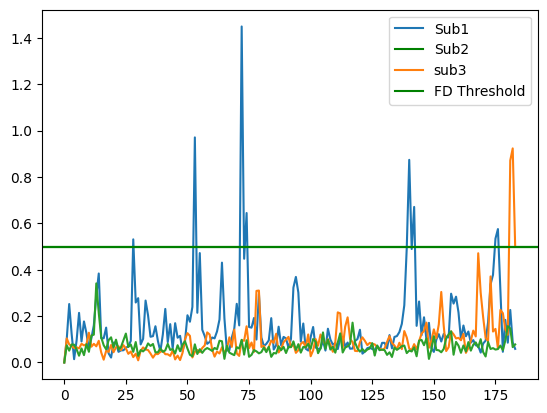

In [6]:
# Getting the frames to censor
f_censor = []
for ii in confounds:
  frames = []
  vec = np.repeat(0,len(ii.FramewiseDisplacement))
  vec[np.array(np.where(ii.loc[:,"FramewiseDisplacement"] > 0.5)[0])] = 1
  frames.append(vec)
  f_censor.append(frames)
  ii.FramewiseDisplacement.plot()
  plt.axhline(y=0.5, color='g', linestyle='-')
  plt.legend(['Sub1','Sub2',"sub3" ,'FD Threshold'])

In [7]:
ind = 0
for ii in confounds:
  ii["censor"] = f_censor[ind][0]
  ind += 1

In [8]:
for ii in range(len(events)):
  events[ii].loc[np.where(events[ii].TrialOutcome == "JUNK")[0], "TrialOutcome"] = "UnsuccessfulGo"



### Downloading the parcelation and applying it to the data

In [9]:

atlas_files = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois = 200, yeo_networks = 17)


[fetch_atlas_schaefer_2018] Dataset created in /root/nilearn_data/schaefer_2018

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_17Networks_order.txt ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_17Networks_order_FSLMNI152_1mm
.nii.gz ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

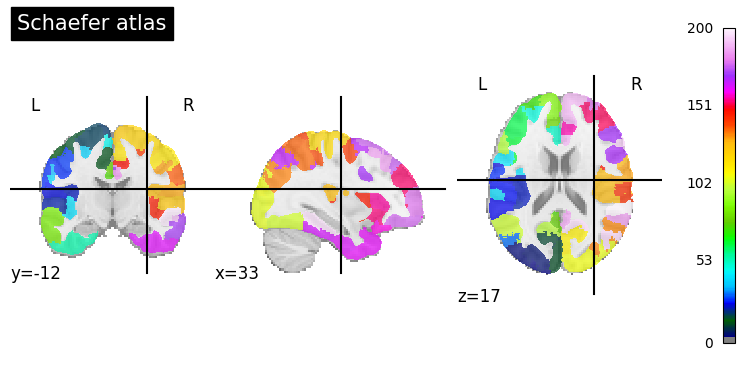

In [10]:
# loading atlas
atlas = nilearn.image.load_img(atlas_files["maps"])
# getting region names
labels = atlas_files["labels"]
# formatting into a form we can use
node_names = []
for label_byte in labels[1:]:
  # Decode the bytes object to a string and then slice it
  node_names.append(label_byte.split("s_")[1])

# plotting atlas
nilearn.plotting.plot_roi(atlas, title="Schaefer atlas")

In [11]:
# getting the names we want
names = [region for region in node_names if "PFCld" in region
         or "RH_SalVentAttnA_Ins" in region
         or "Networks_RH_SalVentAttnA_FrOper_1" in region
         or "SomMotA_4" in region
         or "ContA_PFCd_1" in region
         or "ContA_PFCl_1" in region
         or "DorsAttnA_SPL_1" in region
         or "SalVentAttnA_FrMed_1" in region]

# Getting their location in the atlas
node = []
for i in names:
  node.append((int(np.where(np.array(node_names) == i)[0][0])+1)) ## We +1 to properly allign names with parcelation


Subject 10159
   Design matrix shape: (184, 650)
   Number of FIR regressors: 640
   NaN parcels:  0
   zscore NaN parcels:  0
Subject 10171
   Design matrix shape: (184, 650)
   Number of FIR regressors: 640
   NaN parcels:  0
   zscore NaN parcels:  0
Subject 10189
   Design matrix shape: (184, 650)
   Number of FIR regressors: 640
   NaN parcels:  0
   zscore NaN parcels:  0


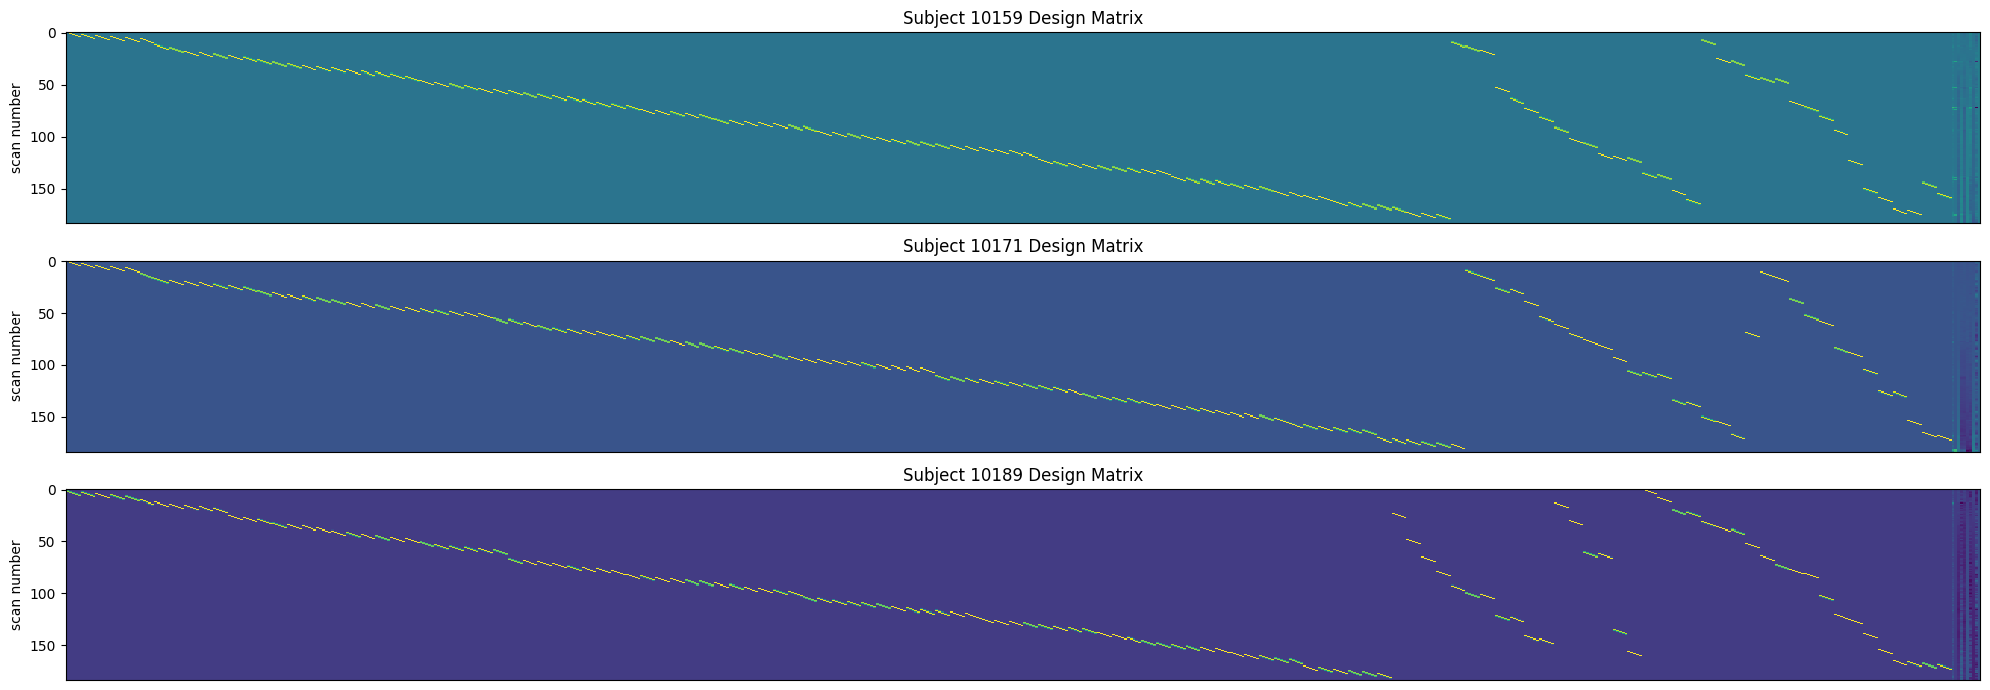

In [12]:
# import warnings
# warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
  # We suppress this becasue we are not working with z_scores from the GLM - the GLM is having issues with the background zscore calculation but we are not reguesting them - we are requesting the betas
  # These betas are not the cause of the sqrt error - that is from zscoring in the GLM. We instead zscore outside the model using a model to that does cause this issue.
  # We also just checked to make sure there were no 0 values - and there were none - indicating that we do not have to be concerned about this in our model - so we just suppress it.

fir_delays = [0, 1, 2, 3, 4]  # 4 FIR bins
n_bins = len(fir_delays)

label_masker = NiftiLabelsMasker(
    labels_img=atlas,
    standardize=False, # with the FIR setup this will cause 0's so we will instead standardize the betas after estimation
    verbose=0
)

clean_img_fir = [] # betas as is
clean_img_fir_z = [] # zscored - standardized - values after estimating fir
clean_img_fir_predicted = [] # to obtain dense continuous predicted timeseires for modeling and checking
clean_img_fir_predicted_z = [] # to zscore predicted ts
clean_img_fir_resid = [] # to obtain non-task timeseires for modeling and checking
clean_img_fir_resid_z = [] # to zscore residual ts

fig, axes = plt.subplots(len(imgs), 1, figsize=(20, 7))

for ii in range(len(imgs)):
    print(f"Subject {models[ii].subject_label}")

    ev = events[ii][["onset", "duration", "TrialOutcome"]].copy()
    ev.columns = ["onset", "duration", "trial_type"]
    ev = ev.loc[ev["trial_type"].notna()].copy()

    # Assign unique trial labels
    trial_ids = []
    trial_counter = {}
    for idx, row in ev.iterrows():
        ttype = row["trial_type"]
        trial_counter[ttype] = trial_counter.get(ttype, 0) + 1
        trial_ids.append(f"{ttype}__{trial_counter[ttype]:03d}")
    ev["trial_type"] = trial_ids

    model = nilearn.glm.first_level.FirstLevelModel(
        t_r=models[ii].t_r,
        hrf_model='fir',
        fir_delays=fir_delays,
        drift_model=None,
        high_pass=None,
        standardize=True,
        signal_scaling=False,
        minimize_memory=False,
        n_jobs=-1
    )

    model_fit = model.fit(
        imgs[ii],
        events=ev,
        confounds=confounds[ii][[
            "FramewiseDisplacement", "censor", "X", "Y", "Z",
            "RotX", "RotY", "RotZ", "WhiteMatter"
        ]]
    )

    dm = model_fit.design_matrices_[0]
    fir_cols = [c for c in dm.columns if "__" in c and "delay_" in c]

    print("   Design matrix shape:", dm.shape)
    print(f"   Number of FIR regressors: {len(fir_cols)}")

    # Build individual contrasts for each FIR regressor
    region_fir_array = []
    for fir_idx in range(len(fir_cols)):
        contrast = np.zeros(dm.shape[1])
        contrast[dm.columns.get_loc(fir_cols[fir_idx])] = 1.0

        try:
            map_img = model_fit.compute_contrast(
                contrast,
                output_type="effect_size"
            )
            region_vals = label_masker.fit_transform(map_img)  # shape: (1, n_parcels)
            region_fir_array.append(region_vals)#[0])  # remove singleton dim
        except np.linalg.LinAlgError:
            print(f"Singular matrix for {fir_cols[fir_idx]} — skipping.")
            region_fir_array.append(np.full((label_masker.fit(imgs[ii]).shape[1],), np.nan))

    region_fir_array = np.array(region_fir_array)  # shape: (n_trials * n_bins, n_nodes)
    print("   NaN parcels: ", np.isnan(region_fir_array).sum())

    # Reshape to (n_trials, n_bins, n_nodes)
    n_trials = len(ev)
    region_fir_array = region_fir_array.reshape(n_trials, n_bins, -1)
    clean_img_fir.append(region_fir_array)
    # zscore
      # zscore strategy
        # First zscore on nodes then on time inroder to preserve fir delay as is but removes trial and node scale
        # This is to ensure the GMMHMM sees well-scaled features per timepoint, but not features that destroy temporal encoding
    z_node = scipy.stats.zscore(region_fir_array, axis=2) # standardizing across nodes (axis=2) for spatial normalization
    z_time = scipy.stats.zscore(np.concatenate(z_node,axis=0), axis=0) # standardizing across time (axis=0) to stabalize temporal variance of FIR values
    z_rs = z_time.reshape(region_fir_array.shape) # reshaping to retain the (trial x delay x node) shape
    print("   zscore NaN parcels: ", np.isnan(z_rs).sum())
    clean_img_fir_z.append(z_rs)
    # predicted
    pred_ts = label_masker.fit_transform(model_fit.predicted[0])
    clean_img_fir_predicted.append(pred_ts)
    # predicted zscore
    pred_z_node = scipy.stats.zscore(pred_ts, axis=1) # standardizing across nodes (axis=1) to normalize nodes
    pred_z_time = scipy.stats.zscore(pred_z_node, axis=0) # standardizing across time (axis=0) to stabalize temporal variance of predicted timeseries
    clean_img_fir_predicted_z.append(pred_z_time)
    # residuals
    res_img = nilearn.image.math_img("a - b", a= imgs[ii], b=model_fit.predicted[0])
    res_vals = label_masker.fit_transform(res_img)
    clean_img_fir_resid.append(res_vals)
    # resid zscore
    res_z_node = scipy.stats.zscore(res_vals, axis=1) # standardizing across nodes (axis=1) to normalize nodes
    res_z_delays = scipy.stats.zscore(res_z_node, axis=0) # standardizing across time (axis=0) to stabalize temporal variance of residuals
    clean_img_fir_resid_z.append(res_z_delays)

    nilearn.plotting.plot_design_matrix(dm, axes=axes[ii])
    axes[ii].set_title(f"Subject {models[ii].subject_label} Design Matrix")
    axes[ii].tick_params(axis='x', which='both', top=False, labeltop=False)

plt.tight_layout()
plt.show()



# Here I will cross validate adn test the number of latent states
## HMM latent states 2-5 (start with 1 just to test this out)
### cross validate and examine generalizability of each latent state model
### then do the bootstrapped LRT test to statistically determine significance in improvement


In [13]:
clean_img_fir_z_nodes = []
for ii in range(len(clean_img_fir_z)):
  clean_img_fir_z_nodes.append(np.vstack(clean_img_fir_z[ii][:,:,node]))

In [14]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import adjusted_rand_score

def run_gmmhmm_cv(
    Y,
    state_range=range(2,6),
    groups=None,                 # group/subject ids (same length as Y); if None -> regular KFold
    n_mixtures=2,
    n_splits=5,
    n_starts=3,                  # random restarts per fold
    n_iter=1000,
    random_state=5745,
    true_states=None             # optional: ground-truth states per row (for simulation)
):
    """
    Cross-validate GMM-HMMs and compute generalization metrics for each k.

    Returns
    -------
    results_df : pd.DataFrame
        Columns: [
          'latent_states': int with number of model latent states (k),
          'mean_LL': float with average log likelihood across folds,
          'SE_LL': float with standard error across folds,
          'delta_LL': float with change in log likelihood from prior model (k-1),
          'perc_folds': float with percent of folds outperforming prior model,
          'mean_ARI' (optional): float with average adjusted rand index across folds indicating the percent of folds accuratly recovered #*#
          ]
    fold_details : dict
        Per-k dictionary with lists of per-fold metrics:
        {'k': {'LL_per_obs': [...], 'ARI': [...], 'fold_sizes': [...]} }
    """
    def select_best_k(results_df, delta_thresh=5, wins_thresh=0.70, se_factor=2):
        best_k = None
        for i, row in results_df.iterrows():
            k = row["latent_states"]
            if k == results_df["latent_states"].min():
                continue
            if (row["delta_LL"] > delta_thresh and
                row["delta_LL"] > se_factor * row["SE_LL"] and
                row["perc_folds"] >= wins_thresh):
                best_k = k
                break
        results_df["selected_model"] = results_df["latent_states"] == best_k
        return results_df
    rng = np.random.default_rng(random_state)
    splitter = GroupKFold(n_splits=n_splits) if groups is not None else KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Precompute splits as index arrays
    splits = list(splitter.split(Y, groups=groups) if groups is not None else splitter.split(Y))

    all_k_metrics = {}
    for k in state_range:
        LL_per_obs_folds = []
        ARI_folds = [] if true_states is not None else None
        fold_sizes = []

        for fold_idx, (train_idx, val_idx) in enumerate(splits):
            Y_train, Y_val = Y[train_idx], Y[val_idx]

            # Multiple random starts; keep the model with best validation LL
            best_val_LL = -np.inf
            best_model = None

            for s in range(n_starts):
                seed = int(rng.integers(0, 2**31-1))
                model = hmm.GMMHMM(
                    n_components=k,
                    n_mix=n_mixtures,
                    n_iter=n_iter,
                    random_state=seed
                )
                try:
                    model.fit(Y_train)
                    val_LL = model.score(Y_val)
                    if val_LL > best_val_LL:
                        best_val_LL = val_LL
                        best_model = model
                except Exception:
                    # If a start fails, skip; keep trying other starts
                    continue

            # If *all* starts failed for this fold, record NaN and move on
            if (best_model is None) or (not np.isfinite(best_val_LL)):
                LL_per_obs_folds.append(np.nan)
                if ARI_folds is not None:
                    ARI_folds.append(np.nan)
                fold_sizes.append(len(val_idx))
                continue

            # Held-out LL per observation
            n_obs_val = len(val_idx)
            LL_per_obs_folds.append(best_val_LL / max(1, n_obs_val))
            fold_sizes.append(n_obs_val)

            # Optional: state recovery (simulation) via ARI on held-out split
            if true_states is not None:
                try:
                    z_hat = best_model.predict(Y_val)
                    ARI_folds.append(adjusted_rand_score(true_states[val_idx], z_hat))
                except Exception:
                    ARI_folds.append(np.nan)

        # Aggregate per-k
        LL_per_obs_arr = np.array(LL_per_obs_folds, dtype=float)
        mean_LL = np.nanmean(LL_per_obs_arr)
        se_LL = np.nanstd(LL_per_obs_arr, ddof=1) / np.sqrt(np.sum(~np.isnan(LL_per_obs_arr)))
        mean_ARI = np.nanmean(ARI_folds) if ARI_folds is not None else None

        all_k_metrics[k] = {
            "LL_per_obs_folds": LL_per_obs_folds,
            "mean_LL_per_obs": mean_LL,
            "SE_LL_per_obs": se_LL,
            "mean_ARI": mean_ARI,
            "fold_sizes": fold_sizes
        }

    # Build summary table with Δ vs k-1 and wins proportion
    rows = []
    prev_k = None
    for k in state_range:
        m = all_k_metrics[k]
        delta = np.nan
        wins = np.nan

        if prev_k is not None:
            # Δ mean LL per obs
            delta = m["mean_LL_per_obs"] - all_k_metrics[prev_k]["mean_LL_per_obs"]

            # Proportion of folds where k > k-1 (pairwise per fold)
            a = np.array(m["LL_per_obs_folds"], dtype=float)
            b = np.array(all_k_metrics[prev_k]["LL_per_obs_folds"], dtype=float)
            valid = np.isfinite(a) & np.isfinite(b)
            if valid.any():
                wins = float(np.mean(a[valid] > b[valid]))
            else:
                wins = np.nan

        rows.append({
            "latent_states": k,
            "mean_LL": m["mean_LL_per_obs"],
            "SE_LL": m["SE_LL_per_obs"],
            "delta_LL": delta,
            "perc_folds": wins*100,
            **({"mean_ARI": m["mean_ARI"]} if m["mean_ARI"] is not None else {})
        })
        prev_k = k

    results_df = pd.DataFrame(rows)
    results_df = select_best_k(results_df)
    return results_df, all_k_metrics


In [15]:
Y = np.concatenate(clean_img_fir_z,axis=0).reshape(-1,200)

In [16]:
results_df, details = run_gmmhmm_cv(
    Y,
    state_range=range(2,6),    # k = 2..5
    groups=None,               # or groups=groups for subject-wise CV
    n_mixtures=2,
    n_splits=5,
    n_starts=3,
    n_iter=1000,
    random_state=5745,
    true_states=None           # or a vector of true states for simulation
)

In [17]:
results_df

latent_states     mean_LL     SE_LL  delta_LL  perc_folds  selected_model
0              2 -261.400387  0.743264       NaN         NaN           False
1              3 -254.674064  0.866525  6.726323       100.0            True
2              4 -247.600014  0.890737  7.074051       100.0           False
3              5 -242.726075  0.723557  4.873939       100.0           False

In [18]:
import numpy as np
from hmmlearn import hmm
from joblib import Parallel, delayed

def _fit_best_ll(Y, k, n_mix, n_iter, tol, n_starts, rng, lengths=None):
    """Fit GMMHMM with multiple random starts; return best model and best LL."""
    best_ll = -np.inf
    best_model = None
    for _ in range(n_starts):
        seed = int(rng.integers(0, 2**31-1))
        model = hmm.GMMHMM(
            n_components=k,
            n_mix=n_mix,
            covariance_type="diag",
            n_iter=n_iter,
            tol=tol,
            random_state=seed
        )
        try:
            model.fit(Y, lengths=lengths)
            ll = model.score(Y, lengths=lengths)
            if ll > best_ll:
                best_ll = ll
                best_model = model
        except Exception:
            continue
    return best_model, best_ll

def bootstrap_lrt_fast(
    Y,
    n_states_small,
    n_states_large,
    n_mixtures=2,
    n_iter=100,
    tol=1e-2,
    B=200,
    n_starts=2,
    random_state=42,
    lengths=None,
    n_jobs=-1
):
    """
    Parametric bootstrap LRT for nested GMM-HMM models with independent seeds,
    early stopping, multi-start fits, and joblib parallelism.
    """
    rng = np.random.default_rng(random_state)
    n_samples = Y.shape[0]

    # 1) Fit both models once to the real data (multi-start)
    m_small, ll_small = _fit_best_ll(
        Y, n_states_small, n_mixtures, n_iter, tol, n_starts, rng, lengths
    )
    if m_small is None:
        raise RuntimeError("Null model failed to fit the real data.")

    m_large, ll_large = _fit_best_ll(
        Y, n_states_large, n_mixtures, n_iter, tol, n_starts, rng, lengths
    )
    if m_large is None:
        raise RuntimeError("Alt model failed to fit the real data.")

    T_obs = 2.0 * (ll_large - ll_small)

    # 2) Bootstrap under null (simulate from fitted null with independent seeds)
    sim_seeds = rng.integers(0, 2**31-1, size=B, dtype=np.int64)
    fit_seeds_small = rng.integers(0, 2**31-1, size=B, dtype=np.int64)
    fit_seeds_large = rng.integers(0, 2**31-1, size=B, dtype=np.int64)

    def one_bootstrap(i):
        # fresh RNGs for simulation and fits
        rng_sim = np.random.default_rng(int(sim_seeds[i]))
        # simulate Y* from null; IMPORTANT: vary the random_state each time
        Y_sim, _ = m_small.sample(n_samples, random_state=int(rng_sim.integers(0, 2**31-1)))

        # refit small & large on Y* with multi-start
        rng_fit = np.random.default_rng(int(fit_seeds_small[i]))
        ms_b, ll_s_b = _fit_best_ll(Y_sim, n_states_small, n_mixtures, n_iter, tol, n_starts, rng_fit)

        rng_fit2 = np.random.default_rng(int(fit_seeds_large[i]))
        ml_b, ll_l_b = _fit_best_ll(Y_sim, n_states_large, n_mixtures, n_iter, tol, n_starts, rng_fit2)

        if (ms_b is None) or (ml_b is None) or (not np.isfinite(ll_s_b)) or (not np.isfinite(ll_l_b)):
            return np.nan
        return 2.0 * (ll_l_b - ll_s_b)

    T_boot = Parallel(n_jobs=n_jobs, prefer="processes", verbose=0)(
        delayed(one_bootstrap)(i) for i in range(B)
    )
    T_boot = np.array(T_boot, dtype=float)
    T_boot = T_boot[np.isfinite(T_boot)]

    if T_boot.size == 0:
        raise RuntimeError("All bootstrap fits failed; relax model or increase n_starts.")

    # 3) Empirical p-value (conservative +1 convention)
    p_empirical = (1 + np.sum(T_boot >= T_obs)) / (1 + T_boot.size)

    # Optional diagnostics
    T_obs_per_obs = T_obs / n_samples
    T_boot_per_obs = T_boot / n_samples

    return {
        "T_obs": float(T_obs),
        "T_obs_per_obs": float(T_obs_per_obs),
        "p_empirical": float(p_empirical),
        "T_boot": T_boot,
        "T_boot_per_obs": T_boot_per_obs
    }


In [19]:

lengths = [int(Y.shape[0]/len(clean_img_fir_z))]*len(clean_img_fir_z)

result = bootstrap_lrt_fast(
    Y=Y,
    n_states_small=2,
    n_states_large=3,
    n_mixtures=2,
    n_iter=100,       # much smaller than 1000
    tol=1e-2,         # early stop
    B=1000,            # you can start with 100 while debugging
    n_starts=2,       # 2–3 is plenty for bootstraps
    random_state=5745,
    lengths=lengths,  # important if multiple sequences were concatenated
    n_jobs=-1         # use all cores
)



In [25]:
pd.DataFrame({"t_obs":result["T_obs"], "p": result["p_empirical"], "boot_t":np.mean(result["T_boot"]),"std":np.std(result["T_boot"])}, index=["bootstrapped t"])

t_obs         p       boot_t        std
bootstrapped t  29361.020539  0.000999  1339.655116  34.001471